True essential matrix: [[ 0.         -1.          0.        ]
 [-0.361547    0.         -3.14154162]
 [ 0.          3.          0.        ]]
Computed essential matrix: [[ -4.85388477e-05  -1.00000000e+00  -4.21762070e-04]
 [ -3.62391216e-01  -3.38325541e-02  -3.14887717e+00]
 [  1.45616543e-04   3.00000000e+00   1.26528621e-03]]
True fundamental matrix: [[  0.00000000e+00  -1.11111111e-05   1.66666667e-03]
 [ -4.01718887e-06   0.00000000e+00  -9.86922708e-03]
 [  6.02578330e-04   1.16666667e-02  -2.69615938e-01]]
Computed fundamental matrix: [[  2.27171001e-20  -1.11111111e-05   1.66666667e-03]
 [ -4.01718887e-06  -8.27251455e-20  -9.86922708e-03]
 [  6.02578330e-04   1.16666667e-02  -2.69615938e-01]]
True pose of c2 wrt c1:  [[ 0.90630779  0.          0.42261826 -3.14154162]
 [ 0.          1.          0.          0.        ]
 [-0.42261826  0.          0.90630779  0.361547  ]
 [ 0.          0.          0.          1.        ]]
Calculated camera 2 parameters: [[  9.06308263e-01  -5.8664

<IPython.core.display.Javascript object>


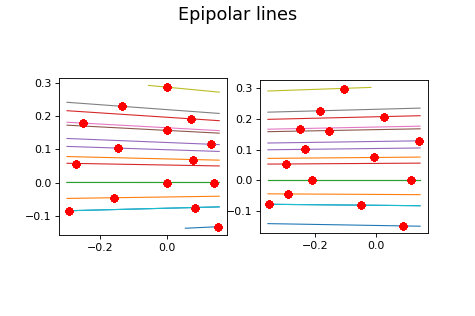

<IPython.core.display.Javascript object>


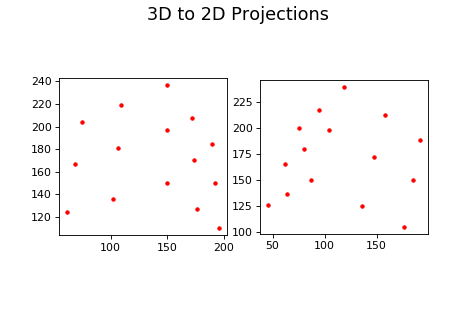

<IPython.core.display.Javascript object>


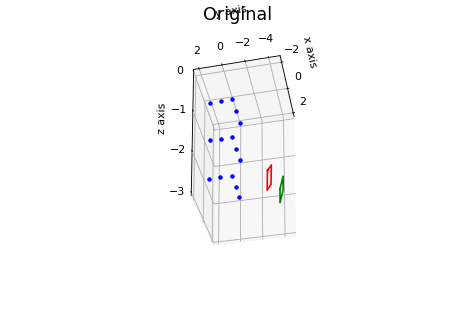

<IPython.core.display.Javascript object>


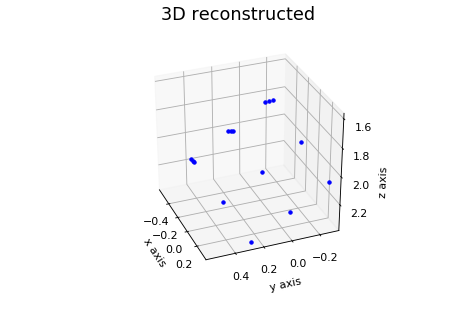

In [3]:
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
import camera
import processor
import structure
import transformers

%matplotlib notebook

def plot_projections(points):
    num_images = len(points)

    plt.figure()
    plt.suptitle('3D to 2D Projections', fontsize=16)
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        ax = plt.gca()
        ax.set_aspect('equal')
        ax.plot(points[i][0], points[i][1], 'r.')


def plot_cube(points3d, title=''):
    fig = plt.figure()
    fig.suptitle(title, fontsize=16)
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal')
    ax.plot(points3d[0], points3d[1], points3d[2], 'b.')
    ax.set_xlabel('x axis')
    ax.set_ylabel('y axis')
    ax.set_zlabel('z axis')
    ax.view_init(elev=135, azim=90)
    return ax

def extrinsic_from_camera_pose(m_c1_wrt_c2):
    # Inverse to get extrinsic matrix from camera to world view
    # http://ksimek.github.io/2012/08/22/extrinsic/
    # Returns homogenous 4x4 extrinsic camera matrix
    # Alternatively, R = R^t, T = -RC
    # Rct = m_c1_wrt_c2[:3, :3].T
    # t = -np.dot(Rct, m_c1_wrt_c2[:3, 3])
    H_m = np.vstack([m_c1_wrt_c2, [0, 0, 0, 1]])
    ext = np.linalg.inv(H_m)
    return ext


def camera_corners(camera, dist=0.25):
    d = dist
    x, y, z = np.ravel(camera.t)
    corners = np.array([
        [x-d, y+d, z],
        [x+d, y+d, z],
        [x+d, y-d, z],
        [x-d, y-d, z],
        [x-d, y+d, z]
    ]).T

    return np.asarray(np.dot(camera.R, corners))


size = 300  # size of image in pixels
center = size / 2
intrinsic = np.array([
    [size, 0, center],
    [0, size, center],
    [0, 0, 1]
])

# Points of on the surface of the cube
points3d = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 1, 2],
    [2, 1, 0, 2, 1, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, -1, -1, -1, -2, -2, -2, 0, 0, -1, -1, -2, -2],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
])

# Define pose of cube with respect to camera1 in world view
rotation_mat = transformers.rotation_3d_from_angles(120, 0, 60)
translation_mat = np.matrix([0, 0, 5]).T
c = camera.Camera(K=intrinsic, R=rotation_mat, t=translation_mat)

# Project 3d points to camera1 on the left
points1 = c.project(points3d)
points1 = processor.cart2hom(points1)

# Get 4x4 homogenous extrinsic parameters of camera 1
H_c1 = np.vstack([c.extrinsic, [0, 0, 0, 1]])

# Define rotation of camera1 wrt camera2 and
# translation of camera2 wrt camera1
rotation_mat_wrt_c1 = transformers.rotation_3d_from_angles(0, -25, 0)
translation_mat_wrt_c1 = np.matrix([3, 0, 1]).T
H_c2_c1 = np.hstack([rotation_mat_wrt_c1, translation_mat_wrt_c1])
H_c1_c2 = extrinsic_from_camera_pose(H_c2_c1)

# Calculate pose of model wrt to camera2 in world view
H_c2 = np.dot(H_c1_c2, H_c1)

# Project 3d points to camera 2 on the right
c2 = camera.Camera(K=intrinsic, R=H_c2[:3, :3], t=H_c2[:3, 3])
points2 = c2.project(points3d)
points2 = processor.cart2hom(points2[:2])

# True essential matrix E = [t]R
true_E = np.dot(structure.skew(translation_mat_wrt_c1), rotation_mat_wrt_c1)
print('True essential matrix:', true_E)

# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
points1n = np.dot(np.linalg.inv(intrinsic), points1)
points2n = np.dot(np.linalg.inv(intrinsic), points2)
E = structure.compute_essential_normalized(points1n, points2n)
print('Computed essential matrix:', (-E / E[0][1]))

# True fundamental matrix F = K^-t E K^-1
true_F = np.dot(np.dot(np.linalg.inv(intrinsic).T, true_E), np.linalg.inv(intrinsic))
F = structure.compute_fundamental_normalized(points1, points2)
print('True fundamental matrix:', true_F)
print('Computed fundamental matrix:', (F * true_F[2][2]))

# Given we are at camera 1, calculate the parameters for camera 2
# Using the essential matrix returns 4 possible camera paramters
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2s = structure.compute_P_from_essential(E)

ind = -1
for i, P2 in enumerate(P2s):
    # Find the correct camera parameters
    d1 = structure.reconstruct_one_point(points1n[:, 0], points2n[:, 0], P1, P2)
    P2_homogenous = extrinsic_from_camera_pose(P2)
    d2 = np.dot(P2_homogenous[:3, :4], d1)

    if d1[2] > 0 and d2[2] > 0:
        ind = i

print('True pose of c2 wrt c1: ', H_c1_c2)
P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
P2f = structure.compute_P_from_fundamental(F)
print('Calculated camera 2 parameters:', P2, P2f)

tripoints3d = structure.reconstruct_points(points1n, points2n, P1, P2)
tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)

structure.plot_epipolar_lines(points1n, points2n, E)
plot_projections([points1, points2])

ax = plot_cube(points3d, 'Original')
cam_corners1 = camera_corners(c)
cam_corners2 = camera_corners(c2)
ax.plot(cam_corners1[0], cam_corners1[1], cam_corners1[2], 'g-')
ax.plot(cam_corners2[0], cam_corners2[1], cam_corners2[2], 'r-')

plot_cube(tripoints3d, '3D reconstructed')
plt.show()

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2

from camera import Camera
import structure
import processor
import features

# Download images from http://www.robots.ox.ac.uk/~vgg/data/data-mview.html

def house():
    input_path = 'imgs/house/'
    camera_filepath = 'imgs/house/3D/house.00{0}.P'

    cameras = [Camera(processor.read_matrix(camera_filepath.format(i)))
            for i in range(9)]
    [c.factor() for c in cameras]

    points3d = processor.read_matrix(input_path + '3D/house.p3d').T  # 3 x n
    points4d = np.vstack((points3d, np.ones(points3d.shape[1])))  # 4 x n
    points2d = [processor.read_matrix(
        input_path + '2D/house.00' + str(i) + '.corners') for i in range(9)]

    index1 = 2
    index2 = 4
    img1 = cv2.imread(input_path + 'house.00' + str(index1) + '.pgm')  # left image
    img2 = cv2.imread(input_path + 'house.00' + str(index2) + '.pgm')

    # fig = plt.figure()
    # ax = fig.gca(projection='3d')
    # ax.plot(points3d[0], points3d[1], points3d[2], 'b.')
    # ax.set_xlabel('x axis')
    # ax.set_ylabel('y axis')
    # ax.set_zlabel('z axis')
    # ax.view_init(elev=135, azim=90)

    # x = cameras[index2].project(points4d)
    # plt.figure()
    # plt.plot(x[0], x[1], 'b.')
    # plt.show()

    corner_indexes = processor.read_matrix(
        input_path + '2D/house.nview-corners', np.int)
    corner_indexes1 = corner_indexes[:, index1]
    corner_indexes2 = corner_indexes[:, index2]
    intersect_indexes = np.intersect1d(np.nonzero(
        [corner_indexes1 != -1]), np.nonzero([corner_indexes2 != -1]))
    corner_indexes1 = corner_indexes1[intersect_indexes]
    corner_indexes2 = corner_indexes2[intersect_indexes]
    points1 = processor.cart2hom(points2d[index1][corner_indexes1].T)
    points2 = processor.cart2hom(points2d[index2][corner_indexes2].T)

    height, width, ch = img1.shape
    intrinsic = np.array([  # for imgs/house
        [2362.12, 0, width / 2],
        [0, 2366.12, height / 2],
        [0, 0, 1]])

    return points1, points2, intrinsic


def dino():
    # Dino
    img1 = cv2.imread('imgs/dinos/viff.003.ppm')
    img2 = cv2.imread('imgs/dinos/viff.001.ppm')
    
    print(img1.shape)
    print(img2.shape)
    
    pts1, pts2 = features.find_correspondence_points(img1, img2)
    points1 = processor.cart2hom(pts1)
    points2 = processor.cart2hom(pts2)

    fig, ax = plt.subplots(1, 2)
    ax[0].autoscale_view('tight')
    ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    ax[0].plot(points1[0], points1[1], 'r.')
    ax[1].autoscale_view('tight')
    ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
    ax[1].plot(points2[0], points2[1], 'r.')
    fig.show()

    height, width, ch = img1.shape
    intrinsic = np.array([  # for dino
        [2360, 0, width / 2],
        [0, 2360, height / 2],
        [0, 0, 1]])

    return points1, points2, intrinsic


points1, points2, intrinsic = dino()

# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
points1n = np.dot(np.linalg.inv(intrinsic), points1)
points2n = np.dot(np.linalg.inv(intrinsic), points2)
E = structure.compute_essential_normalized(points1n, points2n)
print('Computed essential matrix:', (-E / E[0][1]))

# Given we are at camera 1, calculate the parameters for camera 2
# Using the essential matrix returns 4 possible camera paramters
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])
P2s = structure.compute_P_from_essential(E)

ind = -1
for i, P2 in enumerate(P2s):
    # Find the correct camera parameters
    d1 = structure.reconstruct_one_point(
        points1n[:, 0], points2n[:, 0], P1, P2)

    # Convert P2 from camera view to world view
    P2_homogenous = np.linalg.inv(np.vstack([P2, [0, 0, 0, 1]]))
    d2 = np.dot(P2_homogenous[:3, :4], d1)

    if d1[2] > 0 and d2[2] > 0:
        ind = i

P2 = np.linalg.inv(np.vstack([P2s[ind], [0, 0, 0, 1]]))[:3, :4]
#tripoints3d = structure.reconstruct_points(points1n, points2n, P1, P2)
tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)

fig = plt.figure()
fig.suptitle('3D reconstructed', fontsize=16)
ax = fig.gca(projection='3d')
ax.plot(tripoints3d[0], tripoints3d[1], tripoints3d[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()

(576, 720, 3)
(576, 720, 3)


error: /opencv/modules/python/src2/cv2.cpp:163: error: (-215) The data should normally be NULL! in function allocate
